### Import des librairies utiles

In [1]:
import numpy as np
import pandas as pd
import spacy
import pickle
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

### Verbes de la Taxonomie de Bloom

In [2]:
class StatModel():
    """
        Classe Permettant de faire des opérations statistiques relatives à la taxonomie de bloom
    """
    def __init__(self, bloom_verbs=None, columns=['Remembering', 'Understanding', 'Applying', 'Analyzing', 'Evaluating','Creating']):
        """
            Initialisation de la classe de statistique
        """
        # Contient une liste de systaxe;Grammaire
        self.nlp = spacy.load("en_core_web_sm")
        self.columns = columns
        self.verbs = [] # liste de verbes de chaque classe
        self.stemmer = PorterStemmer()
        if bloom_verbs is None:
            i = 0
            for column in columns:
                self.verbs.append(pd.Series(np.ravel(pd.read_csv("./input/verbs/{}.csv".format(column)).values)))
        else:
            self.columns = bloom_verbs.columns
            for column in columns:
                self.verbs.append(bloom_verbs[column])
    
    def tag(self, sentence):
        """
            Transformer une phrase en tag (token) WordNet
        """
        words = word_tokenize(sentence)
        words = pos_tag(words)
        return words

    def paraphraseable(self, tag):
        """
            Dire si un tag (token) est utilisable dans notre échelle de Bloom
        """
        return tag.startswith('NN') or tag == 'VB' or tag.startswith('JJ')

    def pos(self, tag):
        """
            Renvoyer le tag wordnet correspondant
        """
        if tag.startswith('NN'):
            return wn.NOUN
        elif tag.startswith('V'):
            return wn.VERB

    def synonyms(self, word, tag):
        """
            Lister tous les synonymes d'un mot en observant son tag
        """
        lemma_lists = [ss.lemmas() for ss in wn.synsets(word, self.pos(tag))]
        lemmas = [lemma.name() for lemma in sum(lemma_lists, [])]
        return set(lemmas)

    def synonymIfExists(self, sentence):
        """
            Chercher les synonyms de chaque mot dans une phrase s'ils existent 
            pour ses mots
        """
        for (word, t) in self.tag(sentence):
            if self.paraphraseable(t):
                syns = self.synonyms(word, t)
                if syns:
                    if len(syns) > 1:
                        yield [word, list(syns)]
                        continue
            yield [word, []]

    def paraphrase(self, sentence):
        """
            Lister tous les synonymes d'un ensemble de mots
        """
        return [x for x in self.synonymIfExists(sentence)]
    
    def verbs_paraphrase(self, phrase_p):
        """
            Extraire les verbes du résultat de paraphrase
        """
        vp_save = []
        for vp in phrase_p:
            if len(vp[1]) > 0:
                vp_save = np.append(vp_save, [" ".join(v.split("_")) for v in vp[1]])
            else:
                vp_save = np.append(vp_save, vp[0])
        return np.unique(vp_save)
    
    def extract_verbs_one(self, phrase):
        """
            Extraire tous les verbes et synonymes d'une phrase
        """
        doc = self.nlp(phrase)
        doc_verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        phrase_verbs = self.verbs_paraphrase(self.paraphrase(" ".join(doc_verbs)))
        return list(np.unique([self.stemmer.stem(word) for word in phrase_verbs]))
    
    def extract_verbs(self, phrases:np.array):
        """
            Extraire tous les verbes et synonymes d'un ensemble de phrases
        """
        phrase_verbs = [self.extract_verbs_one(p) for p in phrases]
        return phrase_verbs
    
    def count_bloom_verbs(self, verbs_extract=None, phrases=None):
        """
            Compter le nombre de verbes de chaque type présent dans la liste de verbes extraite des phrases
        """
        if verbs_extract is None:
            verbs_extract = self.extract_verbs(phrases)
        else:
            assert verbs_extract is not None and verbs_extract.shape[1] == self.columns.size
        return np.array([[verb.isin(verb_extract).sum() for verb in self.verbs] for verb_extract in verbs_extract])
    
    def generate_bloom_result(self, verbs_extract=None, phrases=None):
        """
            Identique à count_bloom_verbs mais renvoie un dataframe
        """
        if verbs_extract is None:
            verbs_extract = self.count_bloom_verbs(phrases=phrases)
        else:
            assert verbs_extract is not None and verbs_extract.shape[1] == self.columns.size
        return pd.DataFrame(verbs_extract, columns=self.columns)

### Tous les verbes par niveau de la taxonomie de Bloom

In [3]:
with open("./input/verbs.txt", "r") as file:
    print(file.read())

define, describe, identify, list, associate, name, say, show, identify, collect, examine, quote, copy, memorize, recognize, repeat, remember, reproduce, record, retain, associate, cite, describe, define, duplicate, record, enumerate, label, identify, indicate, list, locate, memorize, name, order, recall, recognize, repeat, reproduce, summarize, select
interpret, summarize, convert, distinguish, estimate, generalize, paraphrase, qualify, predict, associate, differentiate, discuss, extend, classify, express, indicate, locate, locate, report, report, select, translate, apprehend, hear, decipher, read, classify, compare, convert, demonstrate, differentiate, say in words, illustrate, explain, express, make analogies, generalize, interpret, paraphrase, predict, reformulate, represent, summarize
apply, change, compile, demonstrate, operate, show, use, solve, calculate, complete, illustrate, examine, modify, tell, change, classify, experiment, stage, employ, illustrate, interpret, operate, pra

In [4]:
with open("./input/verbs.txt", "r") as file:
    verbs = file.readlines()

In [5]:
len(verbs)

6

*Les différents niveau de Bloom*

In [6]:
categories = ["REMEMBERING", "UNDERSTANDING", "APPLYING", "ANALYZING", "EVALUATING", "CREATING"]

In [7]:
verbs_list = []
for cls_verbs, category in zip(verbs, categories):
    cls_verbs = cls_verbs.split(",")
    verbs_list.append(pd.Series(np.unique([v.strip() for v in cls_verbs])))

In [8]:
from IPython import display

*Afficher 5 par catégories*

In [10]:
for verbs, category in zip(verbs_list, categories):
    print(category)
    display.display(verbs.head(5))

REMEMBERING


0    associate
1         cite
2      collect
3         copy
4       define
dtype: object

UNDERSTANDING


0    apprehend
1    associate
2     classify
3      compare
4      convert
dtype: object

APPLYING


0    administer
1         apply
2      assemble
3     calculate
4    categorize
dtype: object

ANALYZING


0      analyze
1      arrange
2    associate
3     break up
4    calculate
dtype: object

EVALUATING


0    appreciate
1         argue
2        attack
3     calculate
4        choose
dtype: object

CREATING


0        adapting
1    anticipating
2       arranging
3      assembling
4        building
dtype: object

In [11]:
import helper

*Plus petite forme de chaque*

In [15]:
verbs_tmp = [verbs for verbs in verbs_list]
verbs_list = []
for verbs in verbs_tmp:
    verbs = verbs.apply(lambda x: helper.stem_word(x))
    verbs_list.append(verbs)

for verbs, category in zip(verbs_list, categories):
    print(category)
    display.display(verbs.sample(5))

REMEMBERING


21     rememb
17       quot
11      label
14      memor
2     collect
dtype: object

UNDERSTANDING


7     differenti
6       demonstr
10         estim
14         gener
17         indic
dtype: object

APPLYING


22    implement
36       sketch
6      classifi
41       verifi
4       categor
dtype: object

ANALYZING


28       oppos
37       separ
10      correl
33    question
7       compar
dtype: object

EVALUATING


28      support
4         choos
1          argu
18        infer
26    recommend
dtype: object

CREATING


8     connect
11    develop
7      compos
24     modifi
18      innov
dtype: object

In [16]:
del verbs_tmp

In [20]:
verbs = verbs_list[0].copy()

In [21]:
verbs.shape

(29,)

In [22]:
verbs.drop_duplicates(keep='first', inplace=True)

In [23]:
verbs = pd.DataFrame(verbs.values, columns=[categories[0]])

verbs.to_csv(f"./output/verbs/{categories[0]}.csv", index=False, header=True)

*Stocker dans les fichiers les différents verbes de chaque classe*

In [26]:
for verbs, category in zip(verbs_list, categories):
    verbs.drop_duplicates(keep='first', inplace=True)
    verbs = pd.DataFrame(verbs.values, columns=[category])
    print(category, verbs.shape[0])
    verbs.to_csv(f"./output/verbs/{category}.csv", index=False, header=True)

REMEMBERING 29
UNDERSTANDING 32
APPLYING 43
ANALYZING 43
EVALUATING 33
CREATING 34


**Nous obtenons ainsi cette distribution de verbes associés à chaque classe**

## Les différents jeux de données

### Jeu de données obtenu du mémoire

In [43]:
questions = pd.read_csv("./input/questions_multi_classification.csv")
questions.head()

,query,Analyzing,Applying,Creating,Evaluating,Remembering,Understanding
0,"""last night i had a horrible nightmare”, said ...",1.0,0.0,0.0,0.0,0.0,1.0
1,"""their own language"" means _ .",0.0,0.0,0.0,0.0,1.0,0.0
2,"""you may think the popular singer jay chow is ...",0.0,0.0,0.0,0.0,0.0,1.0
3,( from 5:59 to ~7:00 ) would n't the amount of...,1.0,0.0,0.0,0.0,0.0,1.0
4,(iv) the possibility of real-time online opera...,0.0,0.0,0.0,0.0,1.0,1.0


In [35]:
categories

['REMEMBERING',
 'UNDERSTANDING',
 'APPLYING',
 'ANALYZING',
 'EVALUATING',
 'CREATING']

In [36]:
"Analyzing".upper()

'ANALYZING'

In [44]:
questions.columns = np.array([column.upper() for column in questions.columns])
#questions.head()

def renames():
    questions.rename(columns={"Analyzing": categories[3], 
                              "Applying": categories[2], 
                              "Creating": categories[5], 
                              "Evaluating": : categories[4], 
                              "Remembering": categories[0], 
                              "Understanding": categories[2]})

In [39]:
list(np.append(np.array(["QUERY"]), categories))

['QUERY',
 'REMEMBERING',
 'UNDERSTANDING',
 'APPLYING',
 'ANALYZING',
 'EVALUATING',
 'CREATING']

In [45]:
questions = questions[list(np.append(np.array(["QUERY"]), categories))]
questions.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""last night i had a horrible nightmare”, said ...",0.0,1.0,0.0,1.0,0.0,0.0
1,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
2,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
3,( from 5:59 to ~7:00 ) would n't the amount of...,0.0,1.0,0.0,1.0,0.0,0.0
4,(iv) the possibility of real-time online opera...,1.0,1.0,0.0,0.0,0.0,0.0


In [46]:
questions.shape

(1389, 7)

In [48]:
questions[categories].sum()

REMEMBERING      628.0
UNDERSTANDING    418.0
APPLYING         182.0
ANALYZING        219.0
EVALUATING       137.0
CREATING         106.0
dtype: float64

*Distribution du jeu de données*

### Jeu de donnéees obtenu de *Learning Q DataSet*

In [63]:
learning_questions = pd.read_csv("./input/tgt-train-class.csv")
learning_questions.sample(5)

,text,target
1354,how many multiplication signs are there ?,0
138018,is this possible : '' 2wc ( sub.2 ) '' ?,5
33498,in the limit of f ( x ) as x approaches negati...,1
114579,"does the molecule nclo ( nitrogen , chlorine ,...",0
112261,at 3:57 what is the name of the cell that is p...,0


In [64]:
for i, category in enumerate(categories):
    learning_questions[category] = (learning_questions["target"]==i).astype(np.int)
learning_questions.head()

,text,target,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,what would a diode look like on a circuit board ?,4,0,0,0,0,1,0
1,what is the direction of current in a circuit ...,0,1,0,0,0,0,0
2,electron flow vs proton flow ?,4,0,0,0,0,1,0
3,why do n't the graphs at 2:33 beyond the momen...,5,0,0,0,0,0,1
4,ie what should the graph look like for higher ...,5,0,0,0,0,0,1


In [65]:
learning_questions.drop(columns=["target"], inplace=True)
learning_questions.rename(columns={"text": "QUERY"}, inplace=True)
learning_questions.sample(5)

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
113289,why do the yellow lines have two arrows ?,0,0,0,0,0,1
47557,at 2:44 theres a car horn ?,1,0,0,0,0,0
185946,how would you use the velocity to find the x a...,0,0,0,0,0,1
1925,how do you make a flexagon without a pattern ?,0,0,0,1,0,0
17144,how can we calculate the theoretical probabili...,0,0,0,1,0,0


In [52]:
learning_questions.shape

(188660, 7)

In [53]:
learning_questions[categories].sum()

REMEMBERING      45376
UNDERSTANDING     8313
APPLYING         23334
ANALYZING        39878
EVALUATING       16573
CREATING         55186
dtype: int64

*Nous obtenons cette distribution pour chaque classe*

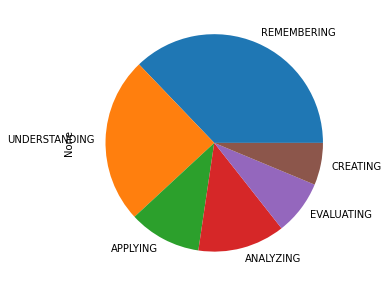

In [55]:
questions[categories].sum().plot.pie(figsize=(5, 5))

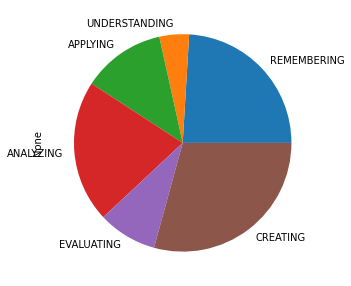

In [57]:
learning_questions[categories].sum().plot.pie(figsize=(5, 5))

*Taille du jeu de données final*

In [58]:
learning_questions.shape[0] + questions.shape[0]

190049

In [60]:
questions[categories].sum(axis=1) == 1

REMEMBERING      False
UNDERSTANDING    False
APPLYING         False
ANALYZING        False
EVALUATING       False
CREATING         False
dtype: bool

In [61]:
questions[questions[categories].sum(axis=1) == 1]

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
1,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
2,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
6,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
7,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
8,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1384,Zhao haitao is proud of his father because his...,1.0,0.0,0.0,0.0,0.0,0.0
1385,Zjenja mentioned exciting opportunities within...,1.0,0.0,0.0,0.0,0.0,0.0
1386,_ and _ are from taiwan.,1.0,0.0,0.0,0.0,0.0,0.0
1387,_ must be disappointed in the end.,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
df = pd.concat([questions[questions[categories].sum(axis=1) == 1], learning_questions], ignore_index=True)
display.display(df.head())
print(f"Shape Of Final DataFrame {df.shape}")

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


Shape Of Final DataFrame (189799, 7)


In [67]:
df[categories].sum()

REMEMBERING      45873.0
UNDERSTANDING     8520.0
APPLYING         23453.0
ANALYZING        39990.0
EVALUATING       16677.0
CREATING         55286.0
dtype: float64

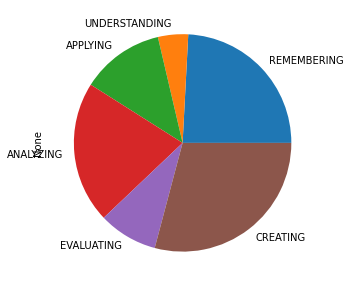

In [68]:
df[categories].sum().plot.pie(figsize=(5, 5))

In [69]:
df.to_csv("./output/queries_df.csv", index=False, header=True)